# Analyze GC SHUFFLE

In [1]:
import glob
from itertools import product
import numpy as np
import os, sys
import pandas as pd
import subprocess as sp

import matplotlib.pyplot as plt
import seaborn as sns


sys.path.append("/wynton/home/ahituv/fongsl/tools/py_")
import config_readwrite as crw

sys.path.append("/wynton/home/ahituv/fongsl/tools/genome")
import gc_content
import chr_functions as chr_

In [2]:
# load config
config_tag = "config-exon.ini"
config, configfile_name = crw.read_config(os.path.join(os.getcwd(), config_tag))

In [3]:
GC_PATH = config["GC"]["PATH"]

# compile df from GC results
#### 1 min 40 seconds

In [4]:
files = glob.glob(os.path.join(GC_PATH,  "*.tsv"))

collection = {}
for f in files:
    if "exon_overlap" in f:
        identity = 'EXON'
    else:
        identity = "NO-EXON"
        
    if "shuf" in f:
        dtype = "SHUF-" + identity
    else:
        dtype = identity
    id_=os.path.basename(f)
    df = pd.read_csv(f, sep='\t', header=None, names=["id", "gc_frac", "gc_dinuc_frac"])
    df['datatype'] = dtype
    collection[id_]=df


len(collection.keys())

1002

In [5]:
df = pd.concat(collection.values())
df = df.loc[df["gc_frac"]!=0]  # 232436 are zero, all ids are in the SHUF-NO-EXON category

print(df.shape)

(8992978, 4)


In [6]:
df.groupby("datatype").describe()

gc_frac                                                    \
                  count      mean       std       min       25%       50%   
datatype                                                                    
EXON             4281.0  0.558964  0.114209  0.266733  0.473526  0.571429   
NO-EXON         14133.0  0.476893  0.107882  0.209790  0.391608  0.460539   
SHUF-EXON     2140500.0  0.458369  0.102410  0.095904  0.379620  0.440559   
SHUF-NO-EXON  6834064.0  0.408005  0.079753  0.000999  0.349650  0.396603   

                                 gc_dinuc_frac                                \
                   75%       max         count      mean       std       min   
datatype                                                                       
EXON          0.645355  0.837163        4281.0  0.104055  0.046458  0.018981   
NO-EXON       0.555445  0.844156       14133.0  0.072690  0.037287  0.013986   
SHUF-EXON     0.526474  0.869131     2140500.0  0.063416  0.032718  0.001998   
SHUF-NO-EXON  0.454545  1.000000     6834064.0  0.048050  0.020198  0.000000   

                                                      
                   25%       50%       75%       max  
datatype                                              
EXON          0.065934  0.099900  0.136863  0.247752  
NO-EXON       0.044955  0.062937  0.091908  0.250749  
SHUF-EXON     0.040959  0.054945  0.076923  0.270729  
SHUF-NO-EXON  0.033966  0.043956  0.056943  0.263736

<AxesSubplot:xlabel='gc_frac', ylabel='Percent'>

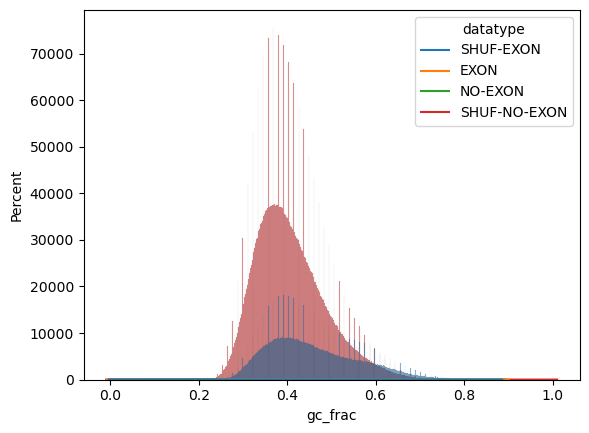

In [7]:
# plot GC fraction

# HIST plot of % of %GC
sns.histplot(x="gc_frac", data=df, hue= "datatype", stat="percent", common_norm=False)

# KDE plot of % of %GC
sns.kdeplot(x="gc_frac", data=df, hue= "datatype",
            #stat="percent", 
            common_norm=False)

# N of % GC
sns.histplot(x="gc_frac", data=df, hue= "datatype")

# HIST plot of % of %GC_DINUCLEOTIDE
sns.histplot(x="gc_dinuc_frac", data=df, hue= "datatype", stat="percent", common_norm=False)

# KDE plot of % of %GC_DINUCLEOTIDE
sns.kdeplot(x="gc_dinuc_frac", data=df, hue= "datatype", 
            #stat="percent", 
            common_norm=False)

# functions to match GC distribution on 

In [8]:
def assignBin(val, bins_list, nbins):
    
    """
    input 
        val(float) - value to be binned.
        bins_list (list) - ascending sorted list of bin values (floats).
        nbins (int) - number of bins considered
    
    method
        1. iterate through bin values (which are in ascending order). 
        2. Find the bin value is greater than or equal to the val-to-be-binned. 
        3. return that value

    return 
        bin label (int) - bin number that the value belongs in. 
        
    """
    #1
    for b, label in zip(bins_list, np.arange(nbins)):
        
        #2
        if b>=val:
            #print(b, val, label)
            
            # 
            return label

In [9]:
def get_95(df, var):
    """
    return top 97.5% and bottom 2.5% values for the column variable in df1
    
    input
        df(pd.DataFrame) - dataframe w/ var 
        var (str) - name of column to get quantiles from. 
    
    method
        pandas quantile function - performed on df[var] series. 
        
    """
    
    return df[var].quantile(0.975), df[var].quantile(0.025)

In [10]:
def matchDf95(df, var, top_975, bottom_025):
    """
    return df subsetted to 95% of data cutoffs (greater than/less than or equal to)
    
    input
        df (pd.Dataframe) - data
        var (str) - name of column to use for cutoff
        top_975 (float) - upper value for var cutoff
        bottom_025 (float) - lower value for var cutoff. 
        
    method
        subset dataframe by var column where:
            df[var] >= bottom025
            and
            df[var] <= top975
    return 
        df_subset (pd dataframe) - subset of dataframe
    """
    df_subset = df.loc[
                (df[var] >= bottom_025)
                & (df[var] <= top_975)
                ]
    return df_subset

In [11]:
def matchDist(df, col_name, dist1, dist2, var, nbins):
    """
    match distribution of dist2 to dist1 on variable

    input
        df (pd dataframe) - dataframe w data on dist1, dist2, var, col_name
        col_name (str) - name of column w categorical EXON, SHUF-EXON, NO-EXON, SHUF-NO-EXON labels
        dist1 (str) - name of the reference distribution to match on
        dist2 (str) - name of the variable distribution that needs to be matched to reference dist. 
        var (str) - name of the variable to match on (column). E.g. gc_content
        nbins (int) - number of equally sized bins to split d1 into. This script tries to match the distribution 
            by separating d2 into equal number of replicate w/ var values similar to d1 bin var values. 
    
    require
        pandas.DataFrame, quantile, qcut, sample
        numpy.unique, arange
        
    method
        1. separate dist1, dist2 into dataframes
        2. match d1, d2 on 95% of dist1 data, removing 5% edges (i.e. top 2.5% and bottom 2.5%). 
            2.1. First get d1 95% of data
            2.2. Second, reduce d1, d2 to 95% data range of d1
            
        3. separate distribution into N bins (int) w pd.qcut
            labels - label w/ bin rank (ordinal) using np.arange
            retbins - return bin values

            makes:
                out (pd.Series) - index and label assignments for input df 
                bins (np.array) - array of bin cut off values, half-open start, fully-closed stop

        4. get counts in each bin, grouping by bin_labels

        5. assign bin labels to df2 using assignBin function (custom) and values of var column
        6. Find out how many instances are in each bin in d2
        7. Select the min value of replicates to select from each bin
        8. Sample the replicate value randomly from each bin. 


    return 
        matched (pd.DataFrame) - dataframe of randomly sampled d2 elements matched on bin size and 95% d1 value dist. 
       
    """

    #1
    df1, df2 = df.loc[df[col_name]==dist1].copy(), df.loc[df[col_name]==dist2].copy()

    #2.1
    d1_top, d1_bottom = get_95(df1, var)
    
    #2.2
    df1 = matchDf95(df1, var, d1_top, d1_bottom)
    df2 = matchDf95(df2, var, d1_top, d1_bottom)

    #3
    out, bins = pd.qcut(df1[var], q=nbins, retbins=True, labels = np.arange(nbins))  # bins are sorted ascending

    #4
    d1_bincounts = out.reset_index().groupby(var).count()

    counts = list(d1_bincounts[d1_bincounts.columns[0]]) # counts are relatively the same in each bin

    #5
    df2["dist1bin"] = df2["gc_frac"].apply(lambda x: assignBin(x, bins, nbins))
    df2["dist1bin"] = df2["dist1bin"].fillna(0) # fill in na when bin is assigned zero. 

    matched, replicates, count_dict = {}, [], {}

    #6 find number of dist2 elements that match dist1 per bin
    for label, c in zip(np.arange(nbins), counts):

        test = df2.loc[df2["dist1bin"]==label]
        n, reps = test.shape[0], test.shape[0]/c # number of dist2 replicates per bin
        replicates.append(reps)  # add replicate number to list to figure out how many elements to sample for each bin. 
        count_dict[label] = [test, n, reps] # save everything to the countdict

    print(sorted(replicates))

    #7 match bin distributions - pick least n replicates to match on for each bin
    n_reps = sorted(replicates)[0]

    #8
    for label, c in zip(np.arange(nbins), counts):
        test, n, reps = count_dict[label]

        # set the number of elements to sample
        if reps < n_reps:
            nsample = int(n)

        else:
            nsample = int(c*n_reps)

        print(c, n, n_reps, nsample)

        random_sampling = test.sample(n=nsample)
        matched[label]=random_sampling

    return pd.concat(matched.values())

# Main
## match distributions


In [12]:
var = "gc_frac"
col_name = "datatype"
nbins = 25

dists = [('EXON', "SHUF-EXON"), ("NO-EXON", "SHUF-NO-EXON")]

results = {}
for dist1, dist2 in dists:
    print(dist1, dist2)
    matched = matchDist(df, col_name, dist1, dist2, var, nbins)
    results[dist1] = matched

EXON SHUF-EXON
[76.42857142857143, 82.78048780487805, 104.72881355932203, 125.39411764705882, 129.5472972972973, 130.87272727272727, 161.91358024691357, 184.83333333333334, 192.77710843373495, 225.61146496815286, 250.33536585365854, 262.8471337579618, 274.3544303797468, 278.812865497076, 347.46783625730995, 370.7245508982036, 448.2207792207792, 650.2341772151899, 753.2682926829268, 910.0759493670886, 935.3170731707318, 959.239263803681, 1260.3609467455622, 1265.6172839506173, 1485.5987261146497]
170 21317 76.42857142857143 12992
157 233239 76.42857142857143 11999
169 213001 76.42857142857143 12916
162 205030 76.42857142857143 12381
158 143792 76.42857142857143 12075
163 156356 76.42857142857143 12457
164 153392 76.42857142857143 12534
164 123536 76.42857142857143 12534
158 102737 76.42857142857143 12075
171 59417 76.42857142857143 13069
154 69026 76.42857142857143 11770
171 47677 76.42857142857143 13069
167 61911 76.42857142857143 12763
158 43348 76.42857142857143 12075
164 41055 76.42

## inspect new exon distribution

             gc_frac  gc_dinuc_frac       dist1bin
count  310977.000000  310977.000000  310977.000000
mean        0.555266       0.094397      11.972998
std         0.105755       0.041417       7.213204
min         0.337662       0.005994       0.000000
25%         0.474525       0.060939       6.000000
50%         0.568432       0.087912      12.000000
75%         0.639361       0.121878      18.000000
max         0.752248       0.242757      24.000000            gc_frac  gc_dinuc_frac
count  4281.000000    4281.000000
mean      0.558964       0.104055
std       0.114209       0.046458
min       0.266733       0.018981
25%       0.473526       0.065934
50%       0.571429       0.099900
75%       0.645355       0.136863
max       0.837163       0.247752


<AxesSubplot:xlabel='gc_frac', ylabel='Percent'>

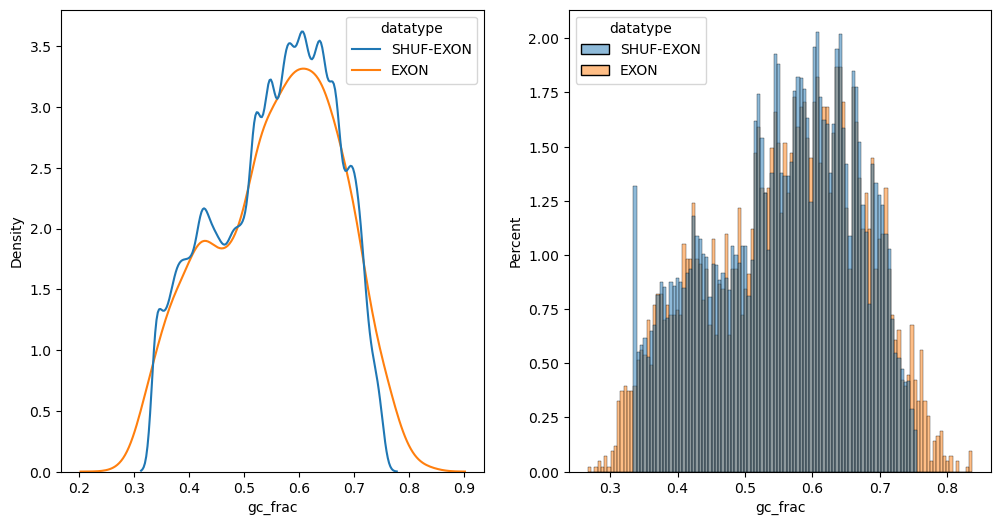

In [15]:
m = results["EXON"]
e = df.loc[df["datatype"]=="EXON"]
me = pd.concat([m,e]) # concat
print(m.describe(), e.describe())

fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize=(12,6))
sns.kdeplot(x="gc_frac", data=me, hue= "datatype",
            #stat="percent", 
            common_norm=False, ax = ax1)


sns.histplot(x="gc_frac", data=me, hue= "datatype",
            stat="percent", 
            common_norm=False,
            ax=ax2)
out=
plt.savefig()

## inspect new non-exon distribution

            gc_frac  gc_dinuc_frac      dist1bin
count  1.003950e+06   1.003950e+06  1.003950e+06
mean   4.685104e-01   6.271433e-02  1.196240e+01
std    9.592131e-02   2.736422e-02  7.220910e+00
min    3.096903e-01   0.000000e+00  0.000000e+00
25%    3.906094e-01   4.195804e-02  6.000000e+00
50%    4.555445e-01   5.694306e-02  1.200000e+01
75%    5.424575e-01   7.792208e-02  1.800000e+01
max    7.042957e-01   2.257742e-01  2.400000e+01             gc_frac  gc_dinuc_frac
count  14133.000000   14133.000000
mean       0.476893       0.072690
std        0.107882       0.037287
min        0.209790       0.013986
25%        0.391608       0.044955
50%        0.460539       0.062937
75%        0.555445       0.091908
max        0.844156       0.250749


<AxesSubplot:xlabel='gc_frac', ylabel='Percent'>

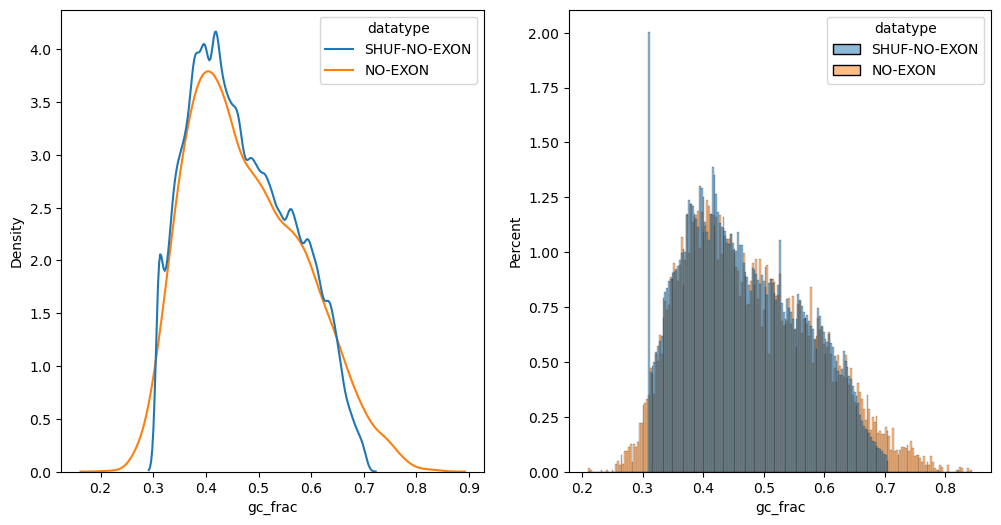

In [16]:
m = results["NO-EXON"]
e = df.loc[df["datatype"]=="NO-EXON"]
me = pd.concat([m,e]) # concat
print(m.describe(), e.describe())

fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize=(12,6))
sns.kdeplot(x="gc_frac", data=me, hue= "datatype",
            #stat="percent", 
            common_norm=False, ax = ax1)


sns.histplot(x="gc_frac", data=me, hue= "datatype",
            stat="percent", 
            common_norm=False,
            ax=ax2)

In [60]:
matched = pd.concat(results.values())
out = f"/wynton/home/ahituv/fongsl/nullomers/data/MATCHED_{var}_nbins-{nbins}.tsv"
matched.to_csv(out, sep='\t', index=False)

In [61]:
out

'/wynton/home/ahituv/fongsl/nullomers/data/MATCHED_gc_frac_nbins-25.tsv'